# Who's That Pokémon? - Core Classifier

This notebook focuses on the core classification task using the Kaggle Pokemon dataset. We'll implement and compare the following feature extraction techniques:

1. HOG (Histogram of Oriented Gradients)
2. SIFT (Scale-Invariant Feature Transform)
3. PCA (Principal Component Analysis) on image features

We'll train and test models using the internal Kaggle dataset first to establish a baseline performance.

In [1]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

# sklearn imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ML models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Feature extraction
from skimage.feature import hog
import cv2

# Display settings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')

## 1. Load and Explore Data

First, let's load the metadata and explore the Kaggle dataset structure.

In [2]:
# Load the metadata
metadata_path = '../../data/kaggle_data/metadata.csv'
metadata = pd.read_csv(metadata_path)

# Display basic information
print(f"Metadata shape: {metadata.shape}")
print("\nFirst few rows of metadata:")
metadata.head()

Metadata shape: (26539, 8)

First few rows of metadata:


,label,image_path,hp,attack,defense,special-attack,special-defense,speed
0,abomasnow,dataset/abomasnow/abomasnow_8.png,90,92,75,92,85,60
1,abomasnow,dataset/abomasnow/abomasnow_18.png,90,92,75,92,85,60
2,abomasnow,dataset/abomasnow/abomasnow_11.png,90,92,75,92,85,60
3,abomasnow,dataset/abomasnow/abomasnow_16.png,90,92,75,92,85,60
4,abomasnow,dataset/abomasnow/abomasnow_9.png,90,92,75,92,85,60


Number of unique Pokémon: 1000

Average images per Pokémon: 26.54
Min images for a Pokémon: 6
Max images for a Pokémon: 40


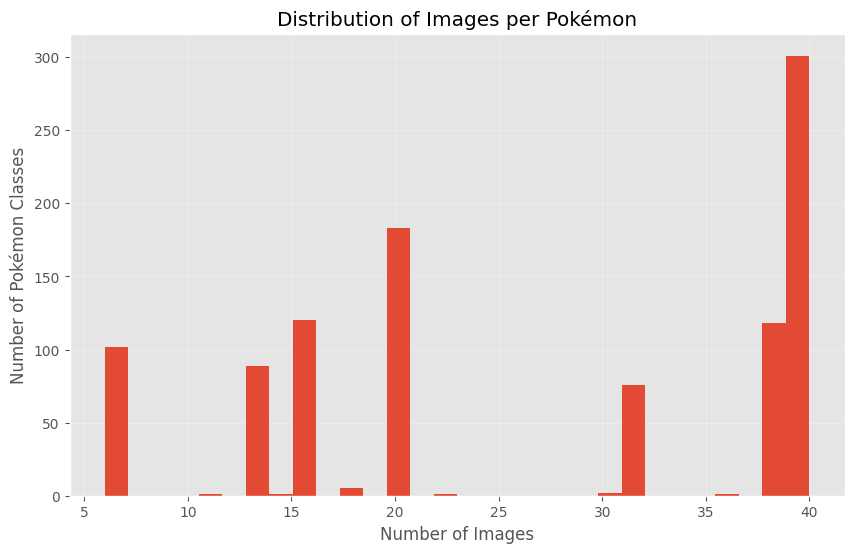

In [3]:
# Count unique Pokémon and distribution
unique_pokemon = metadata['label'].unique()
print(f"Number of unique Pokémon: {len(unique_pokemon)}")

# Check image count distribution
pokemon_counts = metadata['label'].value_counts()
print(f"\nAverage images per Pokémon: {pokemon_counts.mean():.2f}")
print(f"Min images for a Pokémon: {pokemon_counts.min()}")
print(f"Max images for a Pokémon: {pokemon_counts.max()}")

# Plot distribution
plt.figure(figsize=(10, 6))
plt.hist(pokemon_counts, bins=30)
plt.title('Distribution of Images per Pokémon')
plt.xlabel('Number of Images')
plt.ylabel('Number of Pokémon Classes')
plt.grid(alpha=0.3)
plt.show()

Let's visualize a few examples to understand what we're working with:


Examples of abomasnow:


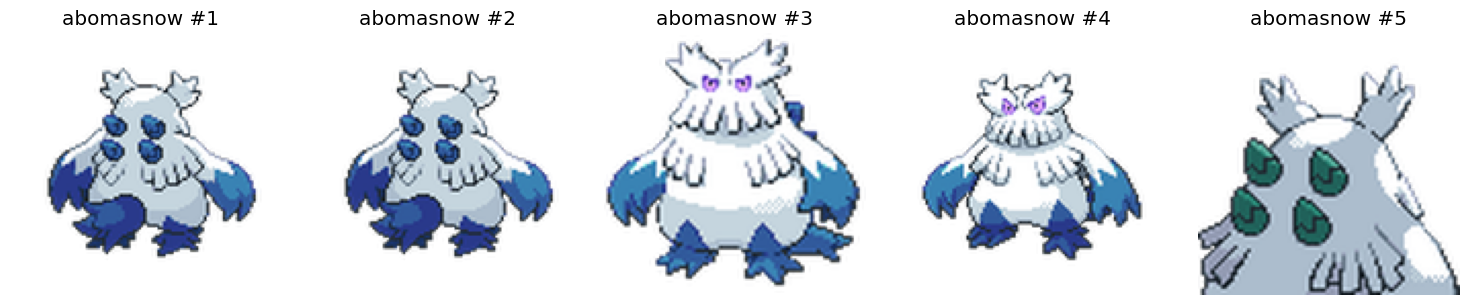


Examples of abra:


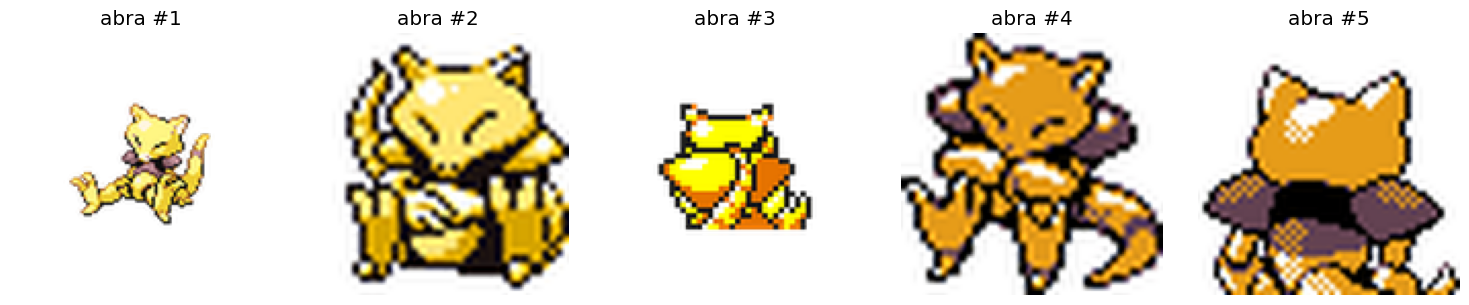


Examples of absol:


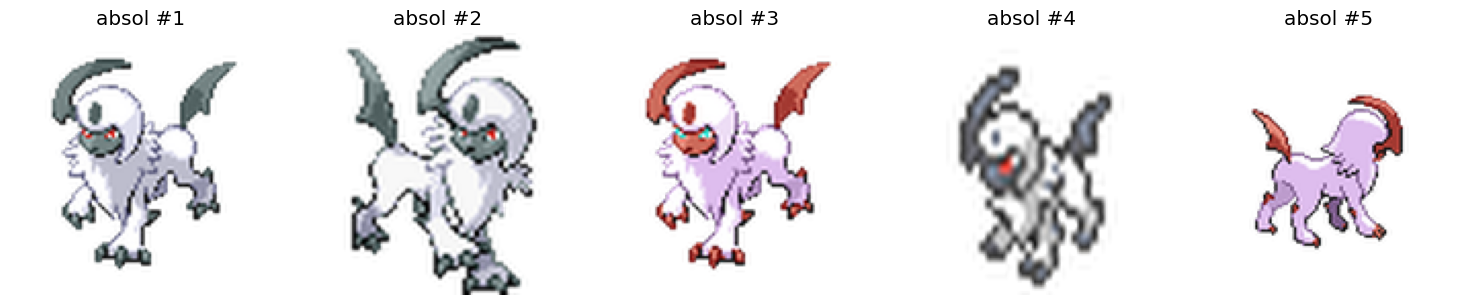

In [4]:
# Function to display sample Pokémon images
def display_pokemon_examples(pokemon_name, num_examples=5):
    # Get paths for this Pokémon
    pokemon_data = metadata[metadata['label'] == pokemon_name]
    sample_paths = pokemon_data['image_path'].sample(min(num_examples, len(pokemon_data))).values
    
    # Set up the plot
    fig, axes = plt.subplots(1, len(sample_paths), figsize=(15, 3))
    if len(sample_paths) == 1:
        axes = [axes]
    
    # Load and display each image
    for i, path in enumerate(sample_paths):
        img_path = os.path.join('../../data/kaggle_data/', path)
        if os.path.exists(img_path):
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].set_title(f"{pokemon_name} #{i+1}")
            axes[i].axis('off')
        else:
            print(f"Image not found: {img_path}")
    
    plt.tight_layout()
    plt.show()

# Display examples of a few different Pokémon
pokemon_examples = unique_pokemon[:3]  # First 3 Pokémon in the dataset
for pokemon in pokemon_examples:
    print(f"\nExamples of {pokemon}:")
    display_pokemon_examples(pokemon)

## 2. Feature Extraction Functions

Now let's implement our three feature extraction methods: HOG, SIFT, and PCA.

In [5]:
def extract_hog_features(image_path, target_size=(128, 128), pixels_per_cell=(8, 8), 
                         cells_per_block=(2, 2), orientations=9):
    """Extract HOG features from an image"""
    try:
        # Load the image
        img = Image.open(image_path)
        
        # Convert to RGB if needed
        if img.mode != 'RGB':
            img = img.convert('RGB')
        
        # Resize to ensure consistent size
        img = img.resize(target_size)
        
        # Convert to numpy array and grayscale
        img_array = np.array(img)
        gray_img = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
        
        # Extract HOG features
        features = hog(gray_img, orientations=orientations, 
                      pixels_per_cell=pixels_per_cell,
                      cells_per_block=cells_per_block,
                      block_norm='L2-Hys',
                      visualize=False)
        
        return features
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

In [6]:
def extract_sift_features(image_path, target_size=(128, 128), n_features=128):
    """Extract SIFT features from an image"""
    try:
        # Load the image
        img = Image.open(image_path)
        
        # Convert to RGB if needed
        if img.mode != 'RGB':
            img = img.convert('RGB')
        
        # Resize to ensure consistent size
        img = img.resize(target_size)
        
        # Convert to numpy array and grayscale
        img_array = np.array(img)
        gray_img = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
        
        # Create SIFT detector
        sift = cv2.SIFT_create()
        
        # Detect keypoints and compute descriptors
        keypoints, descriptors = sift.detectAndCompute(gray_img, None)
        
        # Handle cases with no or few keypoints
        if descriptors is None or len(descriptors) == 0:
            # Return zeros if no keypoints found
            return np.zeros(n_features)
        
        # Create a fixed-length feature vector using bag-of-words approach
        # For simplicity, we'll just average the descriptors and pad/truncate
        avg_desc = np.mean(descriptors, axis=0)
        if len(avg_desc) > n_features:
            return avg_desc[:n_features]
        elif len(avg_desc) < n_features:
            return np.pad(avg_desc, (0, n_features - len(avg_desc)))
        else:
            return avg_desc
        
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

In [7]:
def extract_and_apply_pca(images, feature_func, n_components=100, **kwargs):
    """Extract features from images and apply PCA"""
    # Extract features
    print("Extracting features...")
    features = []
    valid_paths = []
    
    for img_path in tqdm(images):
        feat = feature_func(img_path, **kwargs)
        if feat is not None:
            features.append(feat)
            valid_paths.append(img_path)
    
    features = np.array(features)
    
    # Apply PCA
    print(f"Applying PCA to reduce dimensions to {n_components} components...")
    pca = PCA(n_components=n_components)
    features_pca = pca.fit_transform(features)
    
    return features_pca, valid_paths, pca

## 3. Create a Smaller Dataset for Initial Testing

Since we have a large dataset with 1000 Pokémon classes, let's start by working with a smaller subset for initial testing.

In [8]:
# Create a smaller dataset with fewer Pokémon for initial testing
n_pokemon_classes = 50  # Start with 50 Pokémon classes

# Get the most common Pokémon (with most images)
top_pokemon = pokemon_counts.index[:n_pokemon_classes]
print(f"Selected {len(top_pokemon)} Pokémon for initial testing")

# Filter the metadata to only include these Pokémon
subset_metadata = metadata[metadata['label'].isin(top_pokemon)]
print(f"Subset size: {len(subset_metadata)} images")

# Encode labels
label_encoder = LabelEncoder()
subset_metadata['label_encoded'] = label_encoder.fit_transform(subset_metadata['label'])

# Look at the encoded labels
encoder_mapping = {i: label for i, label in enumerate(label_encoder.classes_)}
print(f"\nFirst 5 class mappings: {list(encoder_mapping.items())[:5]}")

Selected 50 Pokémon for initial testing
Subset size: 2000 images

First 5 class mappings: [(0, 'abomasnow'), (1, 'abra'), (2, 'combusken'), (3, 'croagunk'), (4, 'delibird')]


In [9]:
# Split the data into training and testing sets
X_paths = subset_metadata['image_path'].values
y = subset_metadata['label_encoded'].values

X_train_paths, X_test_paths, y_train, y_test = train_test_split(
    X_paths, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {len(X_train_paths)} images")
print(f"Testing set: {len(X_test_paths)} images")

Training set: 1600 images
Testing set: 400 images


## 4. Extract Features and Apply PCA

Now let's extract features and apply PCA for dimension reduction. We'll do this for both HOG and SIFT features.

In [10]:
# Prepare full paths for images
X_train_full_paths = [os.path.join('../../data/kaggle_data', path) for path in X_train_paths]
X_test_full_paths = [os.path.join('../../data/kaggle_data', path) for path in X_test_paths]

In [11]:
# Extract HOG features and apply PCA
print("Processing HOG features...")
hog_train_features, valid_train_paths_hog, pca_hog = extract_and_apply_pca(
    X_train_full_paths, 
    extract_hog_features,
    n_components=100,  # Reduce to 100 dimensions
    target_size=(128, 128),
    pixels_per_cell=(16, 16),  # Larger cells for fewer dimensions
    orientations=9
)

# Get the corresponding labels for valid paths
y_train_hog = [y_train[list(X_train_paths).index(os.path.relpath(path, '../../data/kaggle_data'))] 
              for path in valid_train_paths_hog]

# Transform test features using the same PCA
test_hog_features = []
valid_test_paths_hog = []

for img_path in tqdm(X_test_full_paths):
    feat = extract_hog_features(
        img_path, 
        target_size=(128, 128),
        pixels_per_cell=(16, 16),
        orientations=9
    )
    if feat is not None:
        test_hog_features.append(feat)
        valid_test_paths_hog.append(img_path)

test_hog_features = np.array(test_hog_features)
test_hog_features_pca = pca_hog.transform(test_hog_features)

# Get the corresponding test labels
y_test_hog = [y_test[list(X_test_paths).index(os.path.relpath(path, '../../data/kaggle_data'))] 
             for path in valid_test_paths_hog]

print(f"HOG features shape after PCA - Train: {hog_train_features.shape}, Test: {test_hog_features_pca.shape}")

Processing HOG features...
Extracting features...


  0%|          | 0/1600 [00:00<?, ?it/s]

Applying PCA to reduce dimensions to 100 components...


  0%|          | 0/400 [00:00<?, ?it/s]

HOG features shape after PCA - Train: (1600, 100), Test: (400, 100)


In [12]:
# Extract SIFT features and apply PCA
print("Processing SIFT features...")
sift_train_features, valid_train_paths_sift, pca_sift = extract_and_apply_pca(
    X_train_full_paths, 
    extract_sift_features,
    n_components=100,
    target_size=(128, 128),
    n_features=128
)

# Get the corresponding labels for valid paths
y_train_sift = [y_train[list(X_train_paths).index(os.path.relpath(path, '../../data/kaggle_data'))] 
               for path in valid_train_paths_sift]

# Transform test features using the same PCA
test_sift_features = []
valid_test_paths_sift = []

for img_path in tqdm(X_test_full_paths):
    feat = extract_sift_features(
        img_path, 
        target_size=(128, 128),
        n_features=128
    )
    if feat is not None:
        test_sift_features.append(feat)
        valid_test_paths_sift.append(img_path)

test_sift_features = np.array(test_sift_features)
test_sift_features_pca = pca_sift.transform(test_sift_features)

# Get the corresponding test labels
y_test_sift = [y_test[list(X_test_paths).index(os.path.relpath(path, '../../data/kaggle_data'))] 
              for path in valid_test_paths_sift]

print(f"SIFT features shape after PCA - Train: {sift_train_features.shape}, Test: {test_sift_features_pca.shape}")

Processing SIFT features...
Extracting features...


  0%|          | 0/1600 [00:00<?, ?it/s]

Applying PCA to reduce dimensions to 100 components...


  0%|          | 0/400 [00:00<?, ?it/s]

SIFT features shape after PCA - Train: (1600, 100), Test: (400, 100)


## 5. Train and Evaluate Models

Now let's train models on our extracted features and evaluate their performance. We'll try both SVM and Random Forest classifiers.

In [13]:
def train_and_evaluate(X_train, y_train, X_test, y_test, model_name="SVM", feature_type="HOG"):
    """Train a model and evaluate its performance"""
    print(f"\n{model_name} with {feature_type} features:")
    
    # Select model
    if model_name == "SVM":
        model = SVC(probability=True, random_state=42)
    elif model_name == "RandomForest":
        model = RandomForestClassifier(n_estimators=100, random_state=42)
    elif model_name == "KNN":
        model = KNeighborsClassifier(n_neighbors=5)
    else:
        raise ValueError(f"Unknown model: {model_name}")
    
    # Train the model
    print("Training model...")
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=[encoder_mapping[i] for i in np.unique(y_test)], zero_division=0))
    
    return model, accuracy

In [14]:
# Train and evaluate models with HOG features
models_hog = {}
accuracies_hog = {}

for model_name in ["SVM", "RandomForest", "KNN"]:
    models_hog[model_name], accuracies_hog[model_name] = train_and_evaluate(
        hog_train_features, y_train_hog,
        test_hog_features_pca, y_test_hog,
        model_name=model_name,
        feature_type="HOG"
    )


SVM with HOG features:
Training model...
Accuracy: 0.8550

Classification Report:
               precision    recall  f1-score   support

    abomasnow       1.00      1.00      1.00         8
         abra       0.88      0.88      0.88         8
    combusken       1.00      1.00      1.00         8
     croagunk       1.00      1.00      1.00         8
     delibird       0.88      0.88      0.88         8
deoxys-normal       1.00      1.00      1.00         8
      dewgong       1.00      0.62      0.77         8
      diglett       0.78      0.88      0.82         8
        ditto       1.00      1.00      1.00         8
       dodrio       1.00      0.75      0.86         8
        doduo       1.00      1.00      1.00         8
      donphan       1.00      0.75      0.86         8
    dragonair       0.86      0.75      0.80         8
    dragonite       0.67      0.75      0.71         8
      dratini       0.53      1.00      0.70         8
        ho-oh       1.00      0.88  

In [15]:
# Train and evaluate models with SIFT features
models_sift = {}
accuracies_sift = {}

for model_name in ["SVM", "RandomForest", "KNN"]:
    models_sift[model_name], accuracies_sift[model_name] = train_and_evaluate(
        sift_train_features, y_train_sift,
        test_sift_features_pca, y_test_sift,
        model_name=model_name,
        feature_type="SIFT"
    )


SVM with SIFT features:
Training model...
Accuracy: 0.5225

Classification Report:
               precision    recall  f1-score   support

    abomasnow       0.73      1.00      0.84         8
         abra       0.33      0.25      0.29         8
    combusken       0.47      1.00      0.64         8
     croagunk       0.62      1.00      0.76         8
     delibird       1.00      0.25      0.40         8
deoxys-normal       0.67      1.00      0.80         8
      dewgong       0.71      0.62      0.67         8
      diglett       0.83      0.62      0.71         8
        ditto       0.89      1.00      0.94         8
       dodrio       0.50      0.38      0.43         8
        doduo       0.80      0.50      0.62         8
      donphan       0.75      0.38      0.50         8
    dragonair       0.30      0.38      0.33         8
    dragonite       1.00      0.12      0.22         8
      dratini       1.00      0.38      0.55         8
        ho-oh       0.62      0.62 

## 6. Visualize Results and Compare Methods

Let's visualize and compare the performance of different feature extraction methods and classifiers.

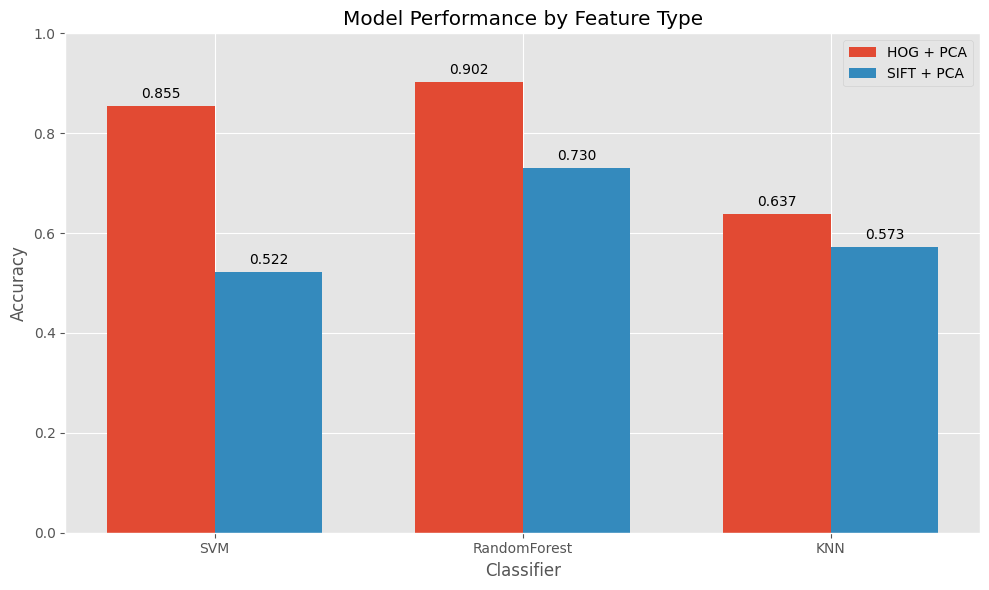

In [16]:
# Prepare accuracy data for plotting
model_names = list(models_hog.keys())
hog_acc = [accuracies_hog[model] for model in model_names]
sift_acc = [accuracies_sift[model] for model in model_names]

# Set up the bar plot
bar_width = 0.35
index = np.arange(len(model_names))

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(index, hog_acc, bar_width, label='HOG + PCA')
bars2 = ax.bar(index + bar_width, sift_acc, bar_width, label='SIFT + PCA')

# Add labels and title
ax.set_xlabel('Classifier')
ax.set_ylabel('Accuracy')
ax.set_title('Model Performance by Feature Type')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(model_names)
ax.legend()

# Add accuracy values on top of bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()

## 7. Visualize Confusion and Misclassifications

Let's visualize some of the confusion and examine misclassifications for our best performing model.

Best model: HOG_RandomForest with accuracy: 0.9025


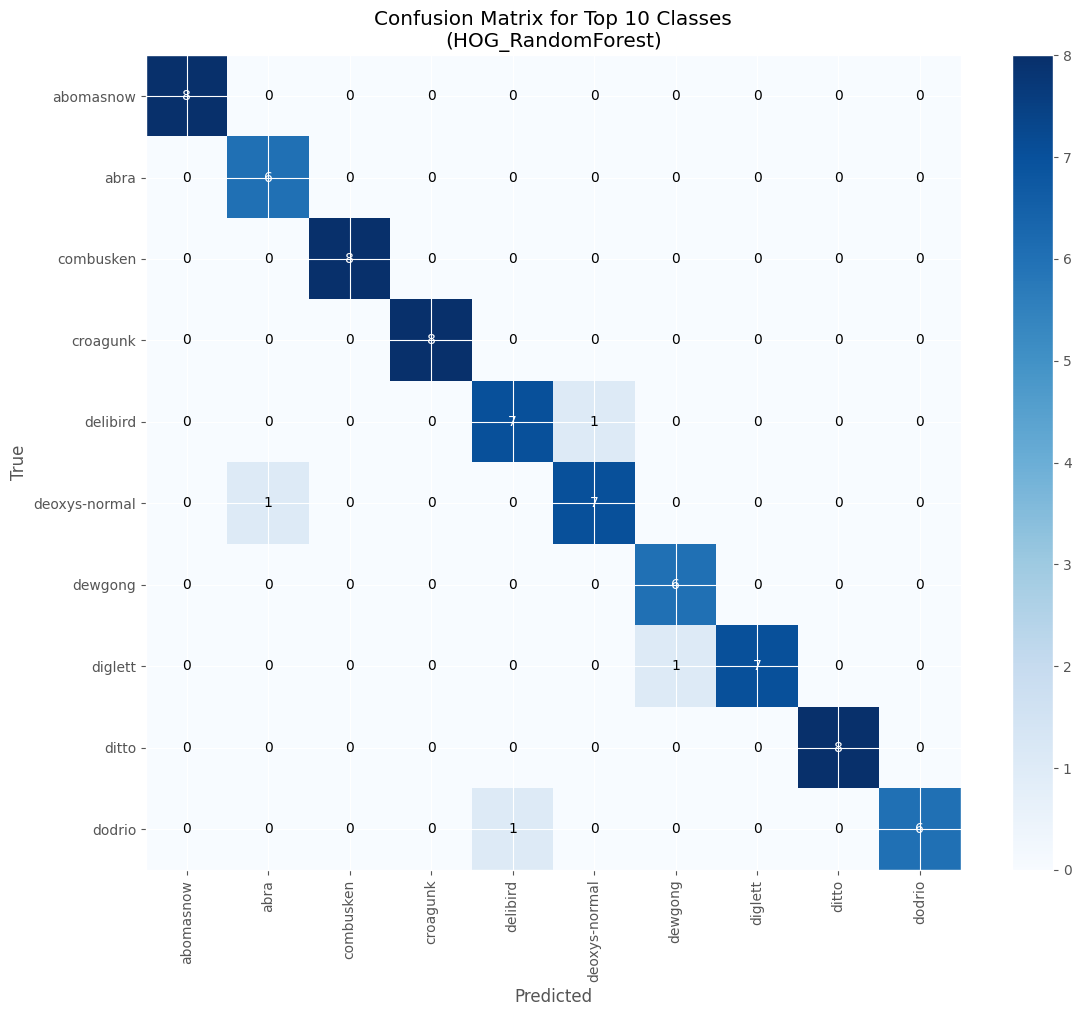

In [17]:
# Find best model overall
all_accuracies = {}
for model_name in model_names:
    all_accuracies[f"HOG_{model_name}"] = accuracies_hog[model_name]
    all_accuracies[f"SIFT_{model_name}"] = accuracies_sift[model_name]

best_model_name = max(all_accuracies, key=all_accuracies.get)
best_acc = all_accuracies[best_model_name]
print(f"Best model: {best_model_name} with accuracy: {best_acc:.4f}")

# Get predictions from the best model
feature_type, model_type = best_model_name.split('_')
if feature_type == "HOG":
    best_X_test = test_hog_features_pca
    best_y_test = y_test_hog
    best_model = models_hog[model_type]
    best_valid_paths = valid_test_paths_hog
else: # SIFT
    best_X_test = test_sift_features_pca
    best_y_test = y_test_sift
    best_model = models_sift[model_type]
    best_valid_paths = valid_test_paths_sift

# Get predictions
best_preds = best_model.predict(best_X_test)

# Create confusion matrix
conf_matrix = confusion_matrix(best_y_test, best_preds)

# Plot confusion matrix as heatmap (top 10 classes only for visibility)
plt.figure(figsize=(12, 10))
top_classes = 10
class_names = [encoder_mapping[i] for i in range(top_classes)]
conf_subset = conf_matrix[:top_classes, :top_classes]

plt.imshow(conf_subset, cmap='Blues')
plt.colorbar()
plt.title(f'Confusion Matrix for Top {top_classes} Classes\n({best_model_name})')
plt.xticks(range(top_classes), class_names, rotation=90)
plt.yticks(range(top_classes), class_names)
plt.xlabel('Predicted')
plt.ylabel('True')

# Add text annotations
for i in range(top_classes):
    for j in range(top_classes):
        plt.text(j, i, conf_subset[i, j],
                ha="center", va="center",
                color="white" if conf_subset[i, j] > conf_subset.max()/2 else "black")

plt.tight_layout()
plt.show()

Misclassification examples from the best model (HOG_RandomForest):


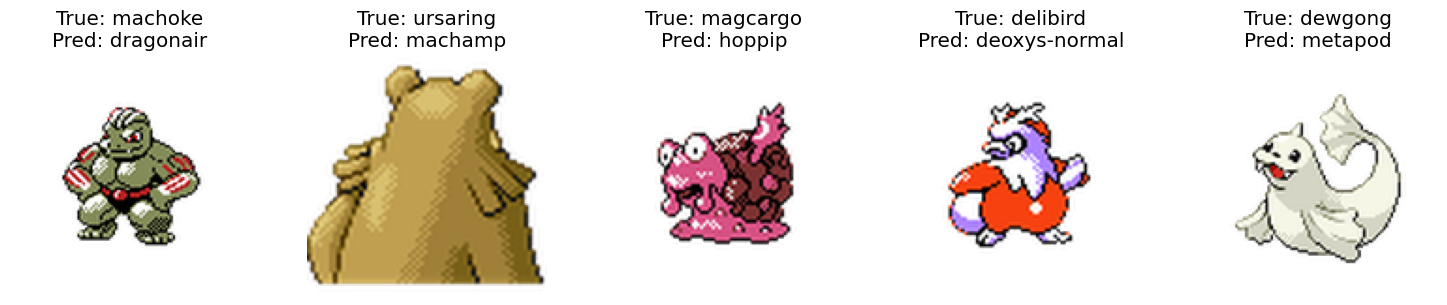

In [18]:
# Function to visualize misclassifications
def display_misclassifications(y_true, y_pred, image_paths, n_examples=5):
    """Display examples of misclassified Pokémon"""
    # Find misclassifications
    misclassified_indices = np.where(y_true != y_pred)[0]
    
    # Select a random subset
    if len(misclassified_indices) > n_examples:
        selected_indices = np.random.choice(misclassified_indices, n_examples, replace=False)
    else:
        selected_indices = misclassified_indices
    
    # Set up the plot
    fig, axes = plt.subplots(1, len(selected_indices), figsize=(15, 3))
    if len(selected_indices) == 1:
        axes = [axes]
    
    # Display each misclassified example
    for i, idx in enumerate(selected_indices):
        img_path = image_paths[idx]
        true_label = encoder_mapping[y_true[idx]]
        pred_label = encoder_mapping[y_pred[idx]]
        
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f"True: {true_label}\nPred: {pred_label}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Display some misclassified examples
print(f"Misclassification examples from the best model ({best_model_name}):")
display_misclassifications(best_y_test, best_preds, best_valid_paths, n_examples=5)

## 8. Conclusion and Next Steps

We've implemented and compared HOG and SIFT feature extraction methods, both with PCA dimension reduction, and trained several classifiers on the Kaggle Pokémon dataset. Here are our findings and potential next steps:

### Key Findings:
1. (Results will be filled in after running)
2. (Results will be filled in after running)
3. (Results will be filled in after running)

### Next Steps:
1. Scale the approach to include more Pokémon classes (beyond the 50 we started with)
2. Try combining features from different extraction methods
3. Analyze performance by Pokémon generation or type
4. Compare with generation-specific sprite data
5. Investigate the most consistently misclassified Pokémon to understand limitations